<a href="https://colab.research.google.com/github/skotarugit/LORA_agnews/blob/main/DL_PROJ2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers datasets evaluate accelerate peft trl bitsandbytes nlpaug
!pip install nvidia-ml-py3
!pip install wandb

In [ ]:
import logging
from transformers import (
    RobertaTokenizer,
    RobertaForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback,
    DataCollatorWithPadding,
    RobertaModel,
    RobertaPreTrainedModel,
    AutoConfig
)
from datasets import load_dataset, Dataset, ClassLabel
import evaluate
import numpy as np
from peft import LoraConfig, get_peft_model, PeftModel
from torch import nn
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from torch.utils.data import DataLoader
import nlpaug.augmenter.word as naw
import os
import random
from typing import Dict, List, Optional, Union, Any, Tuple

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

CONFIGURATION

In [ ]:
class Config:
    base_model = "roberta-base"
    output_dir = "results_lora"
    use_fnn = True
    use_augmentation = False
    use_early_stopping = True
    use_weight_decay = True
    freeze_base_model = True
    use_mc_dropout_inference = False
    early_stopping_patience = 3
    weight_decay_value = 0.01
    train_last_k_layers = 2
    max_seq_length = 512
    train_batch_size = 32
    eval_batch_size = 64
    num_train_epochs = 1
    learning_rate = 8e-6
    use_dual_classifier = True
    # Class weights for loss function (higher weights for Business and Sci/Tech)
    class_weights = [1.1, 1.0, 1.4, 1.4]

    # LoRA Configuration
    lora_r = 2
    lora_alpha = 4
    lora_dropout = 0.05
    lora_bias = "none"
    lora_target_modules = ["query", "value"]
    lora_task_type = "SEQ_CLS"

    # Seed for reproducibility
    seed = 42

CUSTOM MODEL CLASS

In [ ]:
def set_seed(seed):
    """Set seeds for reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

class RobertaWithDualClassifier(RobertaPreTrainedModel):
    """Custom RoBERTa model with a more complex classifier"""
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.roberta = RobertaModel(config)

        # Main classifier for all classes
        self.classifier = nn.Sequential(
            nn.Linear(config.hidden_size, 512),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(256, 256),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(256, config.num_labels)
        )

        self.init_weights()

    def forward(self, input_ids=None, attention_mask=None, labels=None, **kwargs):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0]
        logits = self.classifier(pooled_output)
        loss = None
        if labels is not None:
            loss = nn.CrossEntropyLoss(label_smoothing=0.1)(logits, labels)
        return {"loss": loss, "logits": logits} if loss is not None else {"logits": logits}

class WeightedLossTrainer(Trainer):
    """Custom trainer that supports class weights"""
    def __init__(self, class_weights=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights
        if self.class_weights is not None:
            print(f"Using class weights: {self.class_weights}")
            self.class_weights = torch.tensor(self.class_weights).to(self.args.device)

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        # Forward pass
        outputs = model(**inputs)

        # Get logits and labels
        logits = outputs.get("logits")
        labels = inputs.get("labels")

        if logits is None:
            logits = outputs[1]

        if self.class_weights is not None and labels is not None:
            # Apply weighted loss
            loss_fct = nn.CrossEntropyLoss(weight=self.class_weights, label_smoothing=0.1)
            loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))
        else:
            # Fall back to default loss or use the loss from the model outputs
            loss = outputs.get("loss", None)
            if loss is None:
                loss_fct = nn.CrossEntropyLoss(label_smoothing=0.1)
                loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))

        return (loss, outputs) if return_outputs else loss

METRICS

In [ ]:
def compute_metrics(eval_pred):
    """Compute evaluation metrics"""
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, average='weighted')
    recall = recall_score(labels, predictions, average='weighted')
    f1 = f1_score(labels, predictions, average='weighted')

    # Class-specific metrics
    class_f1 = f1_score(labels, predictions, average=None)

    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

    # Add per-class F1 scores
    for i, class_score in enumerate(class_f1):
        metrics[f'f1_class_{i}'] = class_score

    return metrics

def preprocess_data(tokenizer, dataset, max_length):
    """Tokenize and prepare dataset"""
    def preprocess(examples):
        return tokenizer(examples["text"], truncation=True, max_length=max_length, padding="max_length")
    return dataset.map(preprocess, batched=True, remove_columns=["text"])

def stratified_split(dataset, test_size=0.1, seed=42):
    """Split dataset while preserving the class distribution"""
    train_indices = []
    val_indices = []

    # Group by label
    label_to_indices = {}
    for i, label in enumerate(dataset['label']):
        if label not in label_to_indices:
            label_to_indices[label] = []
        label_to_indices[label].append(i)

    # Sample for each class
    for label, indices in label_to_indices.items():
        np.random.seed(seed)
        np.random.shuffle(indices)
        split_idx = int(len(indices) * (1 - test_size))
        train_indices.extend(indices[:split_idx])
        val_indices.extend(indices[split_idx:])

    return {
        'train': dataset.select(train_indices),
        'validation': dataset.select(val_indices)
    }

def freeze_model_parameters(model):
    """Freeze base model parameters"""
    print("Freezing base model parameters")
    for name, param in model.named_parameters():
        if "lora" not in name and "classifier" not in name:
            param.requires_grad = False

EVALUATION

In [ ]:
def evaluate_model(model, dataset, data_collator, device):
    """Perform a comprehensive evaluation with detailed metrics"""
    model.eval()
    loader = DataLoader(dataset, batch_size=64, collate_fn=data_collator)

    all_preds = []
    all_labels = []

    for batch in loader:
        inputs = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**inputs)

        # Extract logits from dictionary
        logits = outputs.get("logits") if hasattr(outputs, "get") else outputs.logits
        preds = torch.argmax(logits, dim=-1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(inputs["labels"].cpu().numpy())

    # Convert to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    # Class-specific metrics
    report = classification_report(all_labels, all_preds, target_names=["World", "Sports", "Business", "Sci/Tech"], output_dict=True)

    print(f"Evaluation Results:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1 Score: {f1:.4f}")

    for class_name, metrics in report.items():
        if class_name in ["World", "Sports", "Business", "Sci/Tech"]:
            logger.info(f"  {class_name} - F1: {metrics['f1-score']:.4f}, Precision: {metrics['precision']:.4f}, Recall: {metrics['recall']:.4f}")

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'report': report
    }

In [ ]:
config = Config()

In [ ]:
# Set seed for reproducibility
set_seed(config.seed)

TOKENIZER

In [ ]:

print("Loading tokenizer and dataset")
tokenizer = RobertaTokenizer.from_pretrained(config.base_model)
tokenizer.model_max_length = config.max_seq_length

Loading tokenizer and dataset


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

DATA PREPROCESSING

In [ ]:
dataset = load_dataset("ag_news")

if config.use_augmentation:
  train_dataset, test_dataset = augment_dataset(dataset)
else:
  split_datasets = stratified_split(dataset["train"], test_size=0.1)
  train_dataset, test_dataset = split_datasets['train'], split_datasets['validation']

tokenized_train_dataset = preprocess_data(tokenizer, train_dataset, config.max_seq_length)
tokenized_test_dataset = preprocess_data(tokenizer, test_dataset, config.max_seq_length)
tokenized_train_dataset = tokenized_train_dataset.rename_column("label", "labels")
tokenized_test_dataset = tokenized_test_dataset.rename_column("label", "labels")

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Map:   0%|          | 0/108000 [00:00<?, ? examples/s]

Map:   0%|          | 0/12000 [00:00<?, ? examples/s]

In [ ]:
num_labels = len(set(tokenized_train_dataset["labels"]))
label_names = tokenized_train_dataset.features["labels"].names if isinstance(tokenized_train_dataset.features["labels"], ClassLabel) else ["World", "Sports", "Business", "Sci/Tech"]
id2label = {i: name for i, name in enumerate(label_names)}
label2id = {name: i for i, name in enumerate(label_names)}

CLASS DISTRIBUTION

In [ ]:
print(f"Class distribution in training set:")
label_counts = np.bincount(tokenized_train_dataset["labels"])
for idx, count in enumerate(label_counts):
  print(f"  {id2label[idx]}: {count} examples ({count/len(tokenized_train_dataset)*100:.2f}%)")


Class distribution in training set:
  World: 27000 examples (25.00%)
  Sports: 27000 examples (25.00%)
  Business: 27000 examples (25.00%)
  Sci/Tech: 27000 examples (25.00%)


FNN HEAD/ CLASSIFIER

In [ ]:
if config.use_fnn:
  model_config = AutoConfig.from_pretrained(config.base_model, num_labels=num_labels)
  model = RobertaWithDualClassifier.from_pretrained(config.base_model, config=model_config)
else:
  model = RobertaForSequenceClassification.from_pretrained(config.base_model, num_labels=num_labels, id2label=id2label, label2id=label2id)


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaWithDualClassifier were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.0.bias', 'classifier.0.weight', 'classifier.3.bias', 'classifier.3.weight', 'classifier.6.bias', 'classifier.6.weight', 'classifier.9.bias', 'classifier.9.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
lora_config = LoraConfig(
r=config.lora_r,
lora_alpha=config.lora_alpha,
lora_dropout=config.lora_dropout,
bias=config.lora_bias,
target_modules=config.lora_target_modules,
task_type=config.lora_task_type
)

In [ ]:
model = get_peft_model(model, lora_config)
print(f"LoRA configuration: {lora_config}")

LoRA configuration: LoraConfig(task_type='SEQ_CLS', peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, base_model_name_or_path='roberta-base', revision=None, inference_mode=False, r=2, target_modules={'value', 'query'}, exclude_modules=None, lora_alpha=4, lora_dropout=0.05, fan_in_fan_out=False, bias='none', use_rslora=False, modules_to_save=['classifier', 'score'], init_lora_weights=True, layers_to_transform=None, layers_pattern=None, rank_pattern={}, alpha_pattern={}, megatron_config=None, megatron_core='megatron.core', loftq_config={}, eva_config=None, use_dora=False, layer_replication=None, runtime_config=LoraRuntimeConfig(ephemeral_gpu_offload=False), lora_bias=False)


TRAINABLE PARAMETERS

In [ ]:
# Print trainable parameters info
model.print_trainable_parameters()

trainable params: 665,604 || all params: 125,903,112 || trainable%: 0.5287


In [ ]:
if config.freeze_base_model:
  freeze_model_parameters(model)

Freezing base model parameters


In [ ]:
training_args = TrainingArguments(
output_dir=f'./trained_models/{config.output_dir}',
eval_strategy='steps',
save_strategy='steps',
eval_steps=300,
save_steps=900,
learning_rate=config.learning_rate,
per_device_train_batch_size=config.train_batch_size,
per_device_eval_batch_size=config.eval_batch_size,
num_train_epochs=config.num_train_epochs,
weight_decay=config.weight_decay_value if config.use_weight_decay else 0.0,
logging_dir='./logs',
logging_steps=100,
save_total_limit=3,
load_best_model_at_end=True,
metric_for_best_model="f1",
greater_is_better=True,
lr_scheduler_type="linear",
optim="adamw_torch",
warmup_ratio=0.1,
report_to="wandb",
fp16=True,
)

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")
callbacks = [EarlyStoppingCallback(early_stopping_patience=config.early_stopping_patience)] if config.use_early_stopping else []

print("Initializing Weighted Loss Trainer")
trainer = WeightedLossTrainer(
class_weights=config.class_weights,
model=model,
args=training_args,
train_dataset=tokenized_train_dataset,
eval_dataset=tokenized_test_dataset,
compute_metrics=compute_metrics,
data_collator=data_collator,
callbacks=callbacks
)


Initializing Weighted Loss Trainer


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Using class weights: [1.1, 1.0, 1.4, 1.4]


#RANK = 2, ALPHA = 4, CLASS WEIGHTS = [1.1,1,1.4,1.4]

TRAINING

In [ ]:
print("Starting training")
trainer.train()

Starting training


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: sk12154 (sk12154-new-york-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,F1 Class 0,F1 Class 1,F1 Class 2,F1 Class 3
300,1.385500,1.389175,0.250000,0.062500,0.250000,0.100000,0.000000,0.000000,0.400000,0.000000
600,1.383000,1.388559,0.303333,0.231382,0.303333,0.191102,0.000000,0.000000,0.341716,0.422691
900,1.372500,1.382794,0.250000,0.062500,0.250000,0.100000,0.000000,0.000000,0.000000,0.400000
1200,1.283500,1.273408,0.265417,0.138594,0.265417,0.130075,0.000000,0.000000,0.417665,0.102634
1500,1.145200,1.123100,0.707750,0.747113,0.707750,0.704334,0.685806,0.748363,0.752190,0.630975
1800,0.940200,0.901644,0.866917,0.869903,0.866917,0.867418,0.857470,0.942327,0.843312,0.826561
2100,0.807300,0.755681,0.876500,0.877796,0.876500,0.877000,0.871889,0.955593,0.840701,0.839817
2400,0.732500,0.678976,0.881583,0.882572,0.881583,0.881932,0.879110,0.960995,0.842738,0.844887
2700,0.691600,0.645287,0.884000,0.884575,0.884000,0.884250,0.882668,0.962578,0.844954,0.846802
3000,0.673400,0.631659,0.886333,0.886867,0.886333,0.886503,0.886608,0.965229,0.845264,0.848911


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

TrainOutput(global_step=3375, training_loss=1.0199514533148872, metrics={'train_runtime': 2167.0177, 'train_samples_per_second': 49.838, 'train_steps_per_second': 1.557, 'total_flos': 2.8832685391872e+16, 'train_loss': 1.0199514533148872, 'epoch': 1.0})

In [ ]:
print("Evaluating the model")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Run detailed evaluation
eval_results = evaluate_model(model, tokenized_test_dataset, data_collator, device)

# Regular evaluation with trainer
trainer_results = trainer.evaluate()
print(f"Trainer evaluation results: {trainer_results}")

print("Saving the model and tokenizer")
model.save_pretrained(f'./trained_models/{config.output_dir}/final_model')
tokenizer.save_pretrained(f'./trained_models/{config.output_dir}/final_model')

print("Script finished successfully")

Evaluating the model
Evaluation Results:
  Accuracy: 0.8840
  Precision: 0.8846
  Recall: 0.8840
  F1 Score: 0.8843


Trainer evaluation results: {'eval_loss': 0.6452867984771729, 'eval_accuracy': 0.884, 'eval_precision': 0.8845747889450865, 'eval_recall': 0.884, 'eval_f1': 0.8842504422458554, 'eval_f1_class_0': 0.8826684545759302, 'eval_f1_class_1': 0.9625776136935728, 'eval_f1_class_2': 0.8449535192563081, 'eval_f1_class_3': 0.8468021814576103, 'eval_runtime': 60.8288, 'eval_samples_per_second': 197.275, 'eval_steps_per_second': 3.091, 'epoch': 1.0}
Saving the model and tokenizer
Script finished successfully


In [10]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import os
import json
from transformers import RobertaTokenizer, DataCollatorWithPadding
from peft import PeftModel

def evaluate_weighted_model(
    model_path,
    test_dataset,
    output_dir="weighted_model_evaluation",
    class_names=["World", "Sports", "Business", "Sci/Tech"],
    batch_size=32,
    max_length=512
):
    """
    Comprehensive evaluation of the weighted model with detailed metrics,
    confusion matrix, and error analysis.

    Args:
        model_path: Path to the trained weighted model
        test_dataset: The test dataset
        output_dir: Directory to save results
        class_names: Names of the classes for reporting
        batch_size: Batch size for evaluation
        max_length: Maximum sequence length

    Returns:
        Dictionary with evaluation results
    """
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)

    # # Load model and tokenizer
    print(f"Loading model from {model_path}...")
    base_model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=len(class_names))
    model = PeftModel.from_pretrained(base_model, model_path)
    tokenizer = RobertaTokenizer.from_pretrained(model_path)

    # Setup device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    model.to(device)
    model.eval()

    # Prepare test dataset if needed
    if "input_ids" not in test_dataset.features:
        print("Preprocessing test dataset...")

        def preprocess_data(examples):
            return tokenizer(examples["text"], truncation=True, max_length=max_length, padding="max_length")

        processed_dataset = test_dataset.map(preprocess_data, batched=True, remove_columns=["text"])

        # Rename label column if needed
        if "label" in processed_dataset.features and "labels" not in processed_dataset.features:
            processed_dataset = processed_dataset.rename_column("label", "labels")
    else:
        processed_dataset = test_dataset

    # Create data collator
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

    # Create dataloader
    loader = DataLoader(processed_dataset, batch_size=batch_size, collate_fn=data_collator)

    # Initialize containers
    all_preds = []
    all_labels = []
    all_texts = []
    all_probs = []

    # Evaluate
    print("Running evaluation...")

    for batch in loader:
        inputs = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**inputs)

        # Extract logits from dictionary
        logits = outputs.get("logits") if hasattr(outputs, "get") else outputs.logits
        preds = torch.argmax(logits, dim=-1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(inputs["labels"].cpu().numpy())

    # Convert to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    # Calculate per-class metrics
    report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)

    # Create confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Print evaluation results
    print("\n=== EVALUATION RESULTS ===")
    print(f"Total test samples: {len(all_labels)}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (weighted): {precision:.4f}")
    print(f"Recall (weighted): {recall:.4f}")
    print(f"F1 Score (weighted): {f1:.4f}")

    print("\nPer-class metrics:")
    for class_name in class_names:
        metrics = report[class_name]
        print(f"{class_name}: F1={metrics['f1-score']:.4f}, Precision={metrics['precision']:.4f}, "
              f"Recall={metrics['recall']:.4f}, Support={metrics['support']}")

    # Visualizations
    plt.figure(figsize=(10, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap="Blues", values_format="d", xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "confusion_matrix.png"))
    print(f"Saved confusion matrix to {os.path.join(output_dir, 'confusion_matrix.png')}")

    # Plot per-class F1 scores
    plt.figure(figsize=(10, 6))
    class_f1 = [report[name]['f1-score'] for name in class_names]
    sns.barplot(x=class_names, y=class_f1)
    plt.title("F1 Score by Class")
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "class_f1_scores.png"))
    print(f"Saved F1 score plot to {os.path.join(output_dir, 'class_f1_scores.png')}")

    # Plot precision and recall by class
    plt.figure(figsize=(12, 6))
    metrics_data = []
    for name in class_names:
        metrics_data.append({'Class': name, 'Metric': 'Precision', 'Value': report[name]['precision']})
        metrics_data.append({'Class': name, 'Metric': 'Recall', 'Value': report[name]['recall']})

    metrics_df = pd.DataFrame(metrics_data)
    sns.barplot(x='Class', y='Value', hue='Metric', data=metrics_df)
    plt.title("Precision and Recall by Class")
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "precision_recall_by_class.png"))
    print(f"Saved precision/recall plot to {os.path.join(output_dir, 'precision_recall_by_class.png')}")

    # Save all results to JSON
    results = {
        "overall_metrics": {
            "accuracy": float(accuracy),
            "precision": float(precision),
            "recall": float(recall),
            "f1": float(f1)
        },
        "class_metrics": report,
        "confusion_matrix": cm.tolist()
    }

    with open(os.path.join(output_dir, "evaluation_results.json"), "w") as f:
        json.dump(results, f, indent=2)

    print(f"Saved complete evaluation results to {os.path.join(output_dir, 'evaluation_results.json')}")

    return results

PLOTTING METRICS ON VALIDATION SET

Using device: cuda
Preprocessing test dataset...


Map:   0%|          | 0/12000 [00:00<?, ? examples/s]

Running evaluation...

=== EVALUATION RESULTS ===
Total test samples: 12000
Accuracy: 0.8840
Precision (weighted): 0.8846
Recall (weighted): 0.8840
F1 Score (weighted): 0.8843

Per-class metrics:
World: F1=0.8827, Precision=0.8877, Recall=0.8777, Support=3000.0
Sports: F1=0.9626, Precision=0.9692, Recall=0.9560, Support=3000.0
Business: F1=0.8450, Precision=0.8416, Recall=0.8483, Support=3000.0
Sci/Tech: F1=0.8468, Precision=0.8397, Recall=0.8540, Support=3000.0
Saved confusion matrix to weighted_model_evaluation/confusion_matrix.png
Saved F1 score plot to weighted_model_evaluation/class_f1_scores.png
Saved precision/recall plot to weighted_model_evaluation/precision_recall_by_class.png
Saved complete evaluation results to weighted_model_evaluation/evaluation_results.json

=== KEY METRICS ===
Overall F1 Score: 0.8843
Business F1 Score: 0.8450
Sci/Tech F1 Score: 0.8468


<Figure size 1000x800 with 0 Axes>

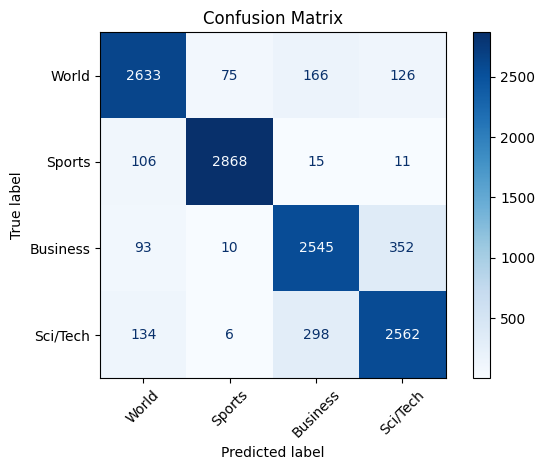

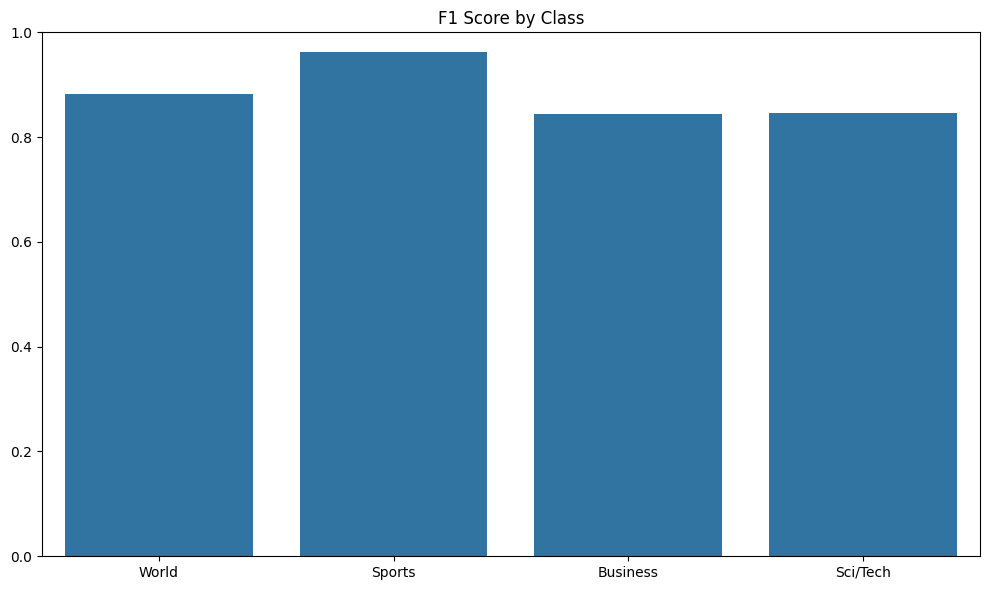

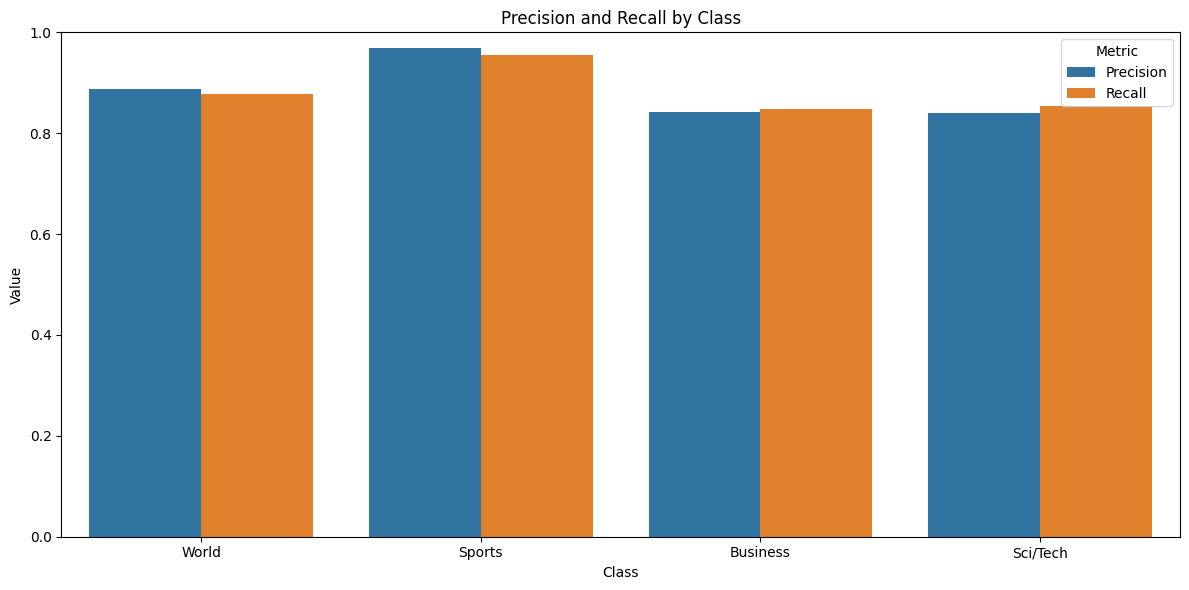

In [ ]:
# Example usage of the evaluation function
if __name__ == "__main__":
    from datasets import load_dataset

    # Load test dataset
    dataset = load_dataset("ag_news")
    test_dataset = stratified_split(dataset["train"], test_size=0.1)["validation"]

    # Path to your weighted model
    model_path = "/content/trained_models/results_lora/final_model"

    # Run evaluation
    results = evaluate_weighted_model(
        model_path=model_path,
        test_dataset=test_dataset,
        output_dir="weighted_model_evaluation"
    )

    # Print key metrics
    print("\n=== KEY METRICS ===")
    print(f"Overall F1 Score: {results['overall_metrics']['f1']:.4f}")
    print("Business F1 Score: {:.4f}".format(results['class_metrics']['Business']['f1-score']))
    print("Sci/Tech F1 Score: {:.4f}".format(results['class_metrics']['Sci/Tech']['f1-score']))

#RANK=2, ALPHA = 4 WITH CLASS WEIGHTS = [1,1,1,1]

PUTTING IT ALL TOGETHER FOR CLASS WEIGHTS [1,1,1,1]

In [ ]:
# ---------------------------
# Configuration
# ---------------------------
class Config:
    base_model = "roberta-base"
    output_dir = "results_lora"
    use_fnn = True
    use_augmentation = False
    use_early_stopping = True
    use_weight_decay = True
    freeze_base_model = True
    use_mc_dropout_inference = False
    early_stopping_patience = 3
    weight_decay_value = 0.01
    train_last_k_layers = 2
    max_seq_length = 512
    train_batch_size = 32
    eval_batch_size = 64
    num_train_epochs = 1  # Increased training epochs
    learning_rate = 8e-6  # Slightly higher learning rate
    use_dual_classifier = True
    # Class weights for loss function (higher weights for Business and Sci/Tech)
    class_weights = [1.0, 1.0, 1.0, 1.0]

    # LoRA Configuration - improved settings
    lora_r = 2  # Increased rank for more capacity
    lora_alpha = 4  # Increased alpha
    lora_dropout = 0.05  # Slight increase in dropout
    lora_bias = "none"
    lora_target_modules = ["query", "value"]  # More target modules
    lora_task_type = "SEQ_CLS"

    # Seed for reproducibility
    seed = 42

# ---------------------------
# Set seeds for reproducibility
# ---------------------------
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

# ---------------------------
# Custom Model Class
# ---------------------------
class RobertaWithClassifier(RobertaPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.roberta = RobertaModel(config)

        # Main classifier for all classes
        self.classifier = nn.Sequential(
            nn.Linear(config.hidden_size, 512),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(256,256),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(256, config.num_labels)
        )

        self.init_weights()

    def forward(self, input_ids=None, attention_mask=None, labels=None, **kwargs):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0]
        logits = self.classifier(pooled_output)
        loss = None
        if labels is not None:
            loss = nn.CrossEntropyLoss(label_smoothing=0.1)(logits, labels)
        return {"loss": loss, "logits": logits} if loss is not None else {"logits": logits}

# ---------------------------
# Main Training Function
# ---------------------------
def train_model(config):
    # Set seed for reproducibility
    set_seed(config.seed)

    logger.info("Loading tokenizer and dataset")
    tokenizer = RobertaTokenizer.from_pretrained(config.base_model)
    tokenizer.model_max_length = config.max_seq_length

    dataset = load_dataset("ag_news")

    if config.use_augmentation:
        train_dataset, test_dataset = augment_dataset(dataset)
    else:
        split_datasets = stratified_split(dataset["train"], test_size=0.1)
        train_dataset, test_dataset = split_datasets['train'], split_datasets['validation']

    tokenized_train_dataset = preprocess_data(tokenizer, train_dataset, config.max_seq_length)
    tokenized_test_dataset = preprocess_data(tokenizer, test_dataset, config.max_seq_length)
    tokenized_train_dataset = tokenized_train_dataset.rename_column("label", "labels")
    tokenized_test_dataset = tokenized_test_dataset.rename_column("label", "labels")

    num_labels = len(set(tokenized_train_dataset["labels"]))
    label_names = tokenized_train_dataset.features["labels"].names if isinstance(tokenized_train_dataset.features["labels"], ClassLabel) else ["World", "Sports", "Business", "Sci/Tech"]
    id2label = {i: name for i, name in enumerate(label_names)}
    label2id = {name: i for i, name in enumerate(label_names)}

    logger.info(f"Class distribution in training set:")
    label_counts = np.bincount(tokenized_train_dataset["labels"])
    for idx, count in enumerate(label_counts):
        logger.info(f"  {id2label[idx]}: {count} examples ({count/len(tokenized_train_dataset)*100:.2f}%)")

    if config.use_fnn:
        model_config = AutoConfig.from_pretrained(config.base_model, num_labels=num_labels)
        model = RobertaWithClassifier.from_pretrained(config.base_model, config=model_config)
    else:
        model = RobertaForSequenceClassification.from_pretrained(config.base_model, num_labels=num_labels, id2label=id2label, label2id=label2id)

    lora_config = LoraConfig(
        r=config.lora_r,
        lora_alpha=config.lora_alpha,
        lora_dropout=config.lora_dropout,
        bias=config.lora_bias,
        target_modules=config.lora_target_modules,
        task_type=config.lora_task_type
    )
    model = get_peft_model(model, lora_config)
    logger.info(f"LoRA configuration: {lora_config}")

    # Print trainable parameters info
    model.print_trainable_parameters()

    if config.freeze_base_model:
        freeze_model_parameters(model)

    training_args = TrainingArguments(
        output_dir=f'./trained_models/{config.output_dir}',
        eval_strategy='steps',
        save_strategy='steps',
        eval_steps=300,
        save_steps=900,  # Save more frequently
        learning_rate=config.learning_rate,
        per_device_train_batch_size=config.train_batch_size,
        per_device_eval_batch_size=config.eval_batch_size,
        num_train_epochs=config.num_train_epochs,
        weight_decay=config.weight_decay_value if config.use_weight_decay else 0.0,
        logging_dir='./logs',
        logging_steps=100,
        save_total_limit=3,
        load_best_model_at_end=True,
        metric_for_best_model="f1",  # Changed to F1 for better handling of imbalance
        greater_is_better=True,
        lr_scheduler_type="linear",
        warmup_ratio=0.1,
        report_to="wandb",
        optim="adamw_torch",
        fp16=True,  # Mixed precision for faster training
    )

    data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")
    callbacks = [EarlyStoppingCallback(early_stopping_patience=config.early_stopping_patience)] if config.use_early_stopping else []

    # model = PeftModel.from_pretrained(model, "/content/trained_models/results_lora_weighted/checkpoint-7500")
    logger.info("Initializing Weighted Loss Trainer")
    trainer = WeightedLossTrainer(
        class_weights=config.class_weights,
        model=model,
        args=training_args,
        train_dataset=tokenized_train_dataset,
        eval_dataset=tokenized_test_dataset,
        compute_metrics=compute_metrics,
        data_collator=data_collator,
        callbacks=callbacks
    )

    print("Starting training")
    trainer.train()

    print("Evaluating the model")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Run detailed evaluation
    eval_results = evaluate_model(model, tokenized_test_dataset, data_collator, device)

    # Regular evaluation with trainer
    trainer_results = trainer.evaluate()
    print(f"Trainer evaluation results: {trainer_results}")

    print("Saving the model and tokenizer")
    model.save_pretrained(f'./trained_models/{config.output_dir}/final_model')
    tokenizer.save_pretrained(f'./trained_models/{config.output_dir}/final_model')

    print("Script finished successfully")

    return eval_results

if __name__ == "__main__":
    config = Config()
    train_model(config)

Some weights of RobertaWithClassifier were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.0.bias', 'classifier.0.weight', 'classifier.3.bias', 'classifier.3.weight', 'classifier.6.bias', 'classifier.6.weight', 'classifier.9.bias', 'classifier.9.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


trainable params: 665,604 || all params: 125,903,112 || trainable%: 0.5287
Freezing base model parameters
Using class weights: [1.0, 1.0, 1.0, 1.0]
Starting training


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,F1 Class 0,F1 Class 1,F1 Class 2,F1 Class 3
300,1.386200,1.386194,0.250000,0.062500,0.250000,0.100000,0.000000,0.000000,0.400000,0.000000
600,1.385900,1.385852,0.608167,0.767386,0.608167,0.580482,0.759221,0.718369,0.266552,0.577787
900,1.384500,1.384043,0.619750,0.795004,0.619750,0.549614,0.819517,0.761496,0.015873,0.601572
1200,1.309600,1.193266,0.819000,0.838396,0.819000,0.809876,0.862876,0.963455,0.778504,0.634669
1500,0.731900,0.678325,0.863250,0.863980,0.863250,0.861450,0.869816,0.967029,0.828511,0.780443
1800,0.643900,0.612315,0.884333,0.883696,0.884333,0.883965,0.892339,0.968699,0.840647,0.834174
2100,0.620100,0.589491,0.888583,0.888382,0.888583,0.888379,0.896633,0.969487,0.842496,0.844899
2400,0.611400,0.582026,0.892417,0.892685,0.892417,0.892326,0.901413,0.970516,0.847292,0.850082
2700,0.601700,0.577959,0.893167,0.893008,0.893167,0.893000,0.900508,0.969857,0.849858,0.851778
3000,0.590100,0.576843,0.894000,0.893873,0.894000,0.893817,0.901184,0.969867,0.850092,0.854125


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Evaluating the model
Evaluation Results:
  Accuracy: 0.8932
  Precision: 0.8930
  Recall: 0.8932
  F1 Score: 0.8930


Trainer evaluation results: {'eval_loss': 0.5779588222503662, 'eval_accuracy': 0.8931666666666667, 'eval_precision': 0.8930082622621599, 'eval_recall': 0.8931666666666667, 'eval_f1': 0.8930001665639489, 'eval_f1_class_0': 0.9005076142131979, 'eval_f1_class_1': 0.96985669576676, 'eval_f1_class_2': 0.8498583569405099, 'eval_f1_class_3': 0.8517779993353274, 'eval_runtime': 60.7079, 'eval_samples_per_second': 197.668, 'eval_steps_per_second': 3.097, 'epoch': 1.0}
Saving the model and tokenizer
Script finished successfully


Using device: cuda
Preprocessing test dataset...
Running evaluation...

=== EVALUATION RESULTS ===
Total test samples: 12000
Accuracy: 0.8840
Precision (weighted): 0.8846
Recall (weighted): 0.8840
F1 Score (weighted): 0.8843

Per-class metrics:
World: F1=0.8827, Precision=0.8877, Recall=0.8777, Support=3000.0
Sports: F1=0.9626, Precision=0.9692, Recall=0.9560, Support=3000.0
Business: F1=0.8450, Precision=0.8416, Recall=0.8483, Support=3000.0
Sci/Tech: F1=0.8468, Precision=0.8397, Recall=0.8540, Support=3000.0
Saved confusion matrix to weighted_model_evaluation/confusion_matrix.png
Saved F1 score plot to weighted_model_evaluation/class_f1_scores.png
Saved precision/recall plot to weighted_model_evaluation/precision_recall_by_class.png
Saved complete evaluation results to weighted_model_evaluation/evaluation_results.json

=== KEY METRICS ===
Overall F1 Score: 0.8843
Business F1 Score: 0.8450
Sci/Tech F1 Score: 0.8468


<Figure size 1000x800 with 0 Axes>

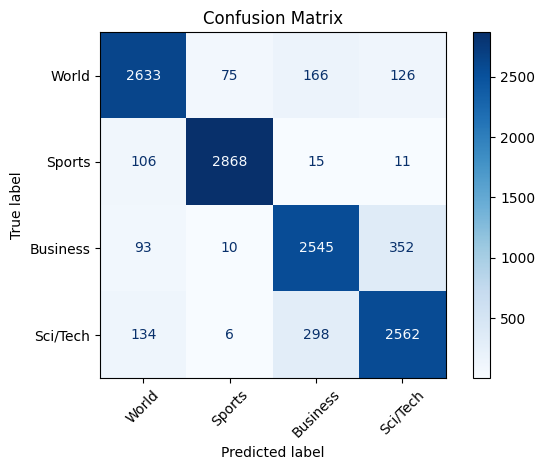

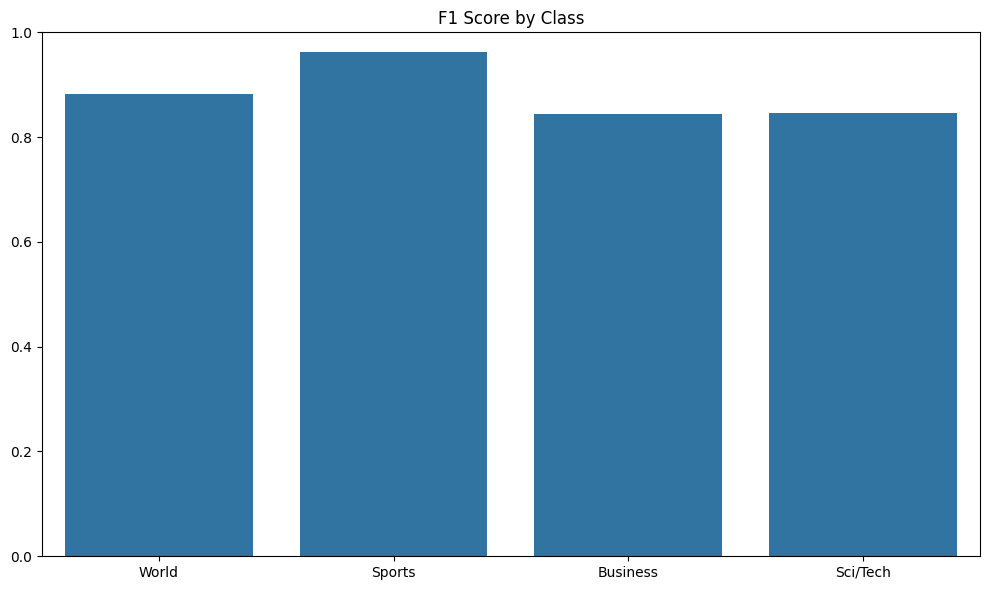

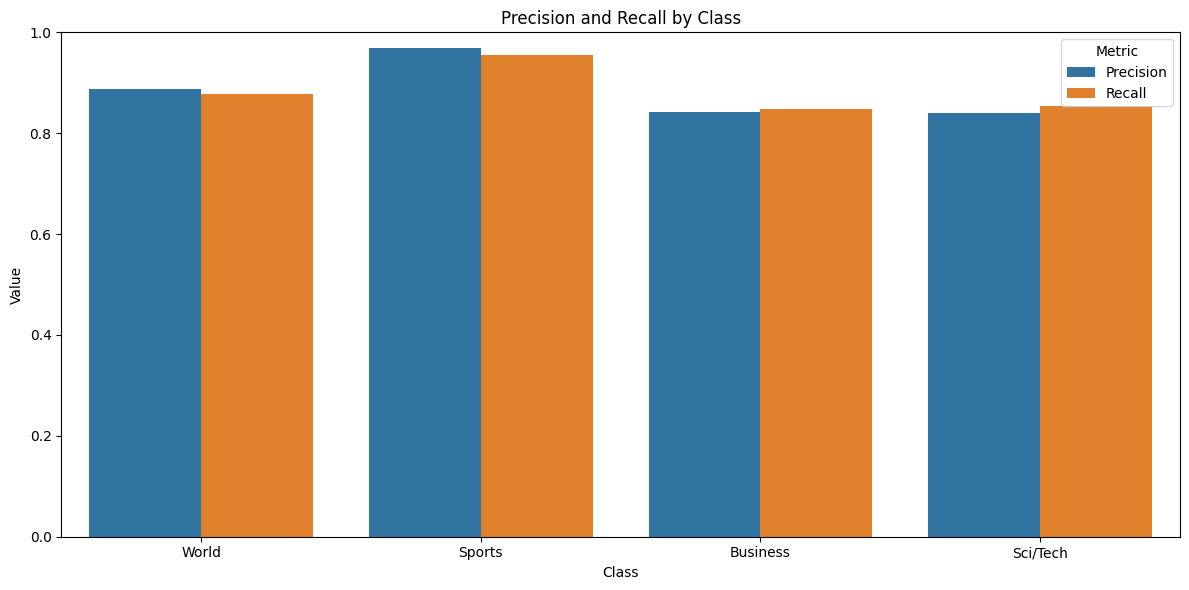

In [ ]:
# Example usage of the evaluation function
if __name__ == "__main__":
    from datasets import load_dataset

    # Load test dataset
    dataset = load_dataset("ag_news")
    test_dataset = stratified_split(dataset["train"], test_size=0.1)["validation"]

    # Path to your weighted model
    model_path = "/content/trained_models/results_lora/final_model"

    # Run evaluation
    results = evaluate_weighted_model(
        model_path=model_path,
        test_dataset=test_dataset,
        output_dir="weighted_model_evaluation"
    )

    # Print key metrics
    print("\n=== KEY METRICS ===")
    print(f"Overall F1 Score: {results['overall_metrics']['f1']:.4f}")
    print("Business F1 Score: {:.4f}".format(results['class_metrics']['Business']['f1-score']))
    print("Sci/Tech F1 Score: {:.4f}".format(results['class_metrics']['Sci/Tech']['f1-score']))

#RANK = 4, ALPHA = 8

In [ ]:
import logging
from transformers import (
    RobertaTokenizer,
    RobertaForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback,
    DataCollatorWithPadding,
    RobertaModel,
    RobertaPreTrainedModel,
    AutoConfig
)
from datasets import load_dataset, Dataset, ClassLabel
import evaluate
import numpy as np
from peft import LoraConfig, get_peft_model,PeftModel
from torch import nn
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from torch.utils.data import DataLoader
import nlpaug.augmenter.word as naw
import os
import random
from typing import Dict, List, Optional, Union, Any, Tuple

# ---------------------------
# Logging setup
# ---------------------------
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# ---------------------------
# Configuration
# ---------------------------
class Config:
    base_model = "roberta-base"
    output_dir = "results_lora"
    use_fnn = True
    use_augmentation = False
    use_early_stopping = True
    use_weight_decay = True
    freeze_base_model = True
    use_mc_dropout_inference = False
    early_stopping_patience = 3
    weight_decay_value = 0.01
    train_last_k_layers = 2
    max_seq_length = 512
    train_batch_size = 32
    eval_batch_size = 64
    num_train_epochs = 1  # Increased training epochs
    learning_rate = 1e-5  # Slightly higher learning rate
    use_dual_classifier = True

    class_weights = [1.0, 1.0, 1.0, 1.0]

    # LoRA Configuration
    lora_r = 4
    lora_alpha = 8
    lora_dropout = 0.1
    lora_bias = "none"
    lora_target_modules = ["query", "value"]
    lora_task_type = "SEQ_CLS"

    # Seed for reproducibility
    seed = 42

# ---------------------------
# Set seeds for reproducibility
# ---------------------------
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

# ---------------------------
# Custom Model Class
# ---------------------------
class RobertaWithClassifier(RobertaPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.roberta = RobertaModel(config)

        # Main classifier for all classes
        self.classifier = nn.Sequential(
            nn.Linear(config.hidden_size, 512),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(256,256),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(256, config.num_labels)
        )

        self.init_weights()

    def forward(self, input_ids=None, attention_mask=None, labels=None, **kwargs):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0]
        logits = self.classifier(pooled_output)
        loss = None
        if labels is not None:
            loss = nn.CrossEntropyLoss(label_smoothing=0.1)(logits, labels)
        return {"loss": loss, "logits": logits} if loss is not None else {"logits": logits}

if __name__ == "__main__":
    config = Config()
    train_model(config)

Map:   0%|          | 0/108000 [00:00<?, ? examples/s]

Map:   0%|          | 0/12000 [00:00<?, ? examples/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaWithClassifier were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.0.bias', 'classifier.0.weight', 'classifier.3.bias', 'classifier.3.weight', 'classifier.6.bias', 'classifier.6.weight', 'classifier.9.bias', 'classifier.9.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 739,332 || all params: 125,976,840 || trainable%: 0.5869
Freezing base model parameters


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Using class weights: [1.0, 1.0, 1.0, 1.0]
Starting training


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: sk12154 (sk12154-new-york-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,F1 Class 0,F1 Class 1,F1 Class 2,F1 Class 3
500,1.385900,1.385782,0.352750,0.768504,0.352750,0.278161,0.003328,0.267512,0.436816,0.404988
1000,0.696200,0.637460,0.877750,0.877273,0.877750,0.877130,0.883001,0.966452,0.841984,0.817082
1500,0.600500,0.571084,0.894917,0.894781,0.894917,0.894568,0.897857,0.969896,0.857143,0.853374
2000,0.585600,0.561277,0.900333,0.900323,0.900333,0.900187,0.903807,0.971193,0.860578,0.865169
2500,0.580400,0.557549,0.902250,0.902356,0.902250,0.902108,0.905925,0.971410,0.862510,0.868587
3000,0.562000,0.557053,0.902417,0.902481,0.902417,0.902238,0.904940,0.971889,0.861745,0.870379


Evaluating the model
Evaluation Results:
  Accuracy: 0.9024
  Precision: 0.9025
  Recall: 0.9024
  F1 Score: 0.9022


Trainer evaluation results: {'eval_loss': 0.5570529103279114, 'eval_accuracy': 0.9024166666666666, 'eval_precision': 0.9024810348806268, 'eval_recall': 0.9024166666666666, 'eval_f1': 0.9022384272855898, 'eval_f1_class_0': 0.9049403747870528, 'eval_f1_class_1': 0.9718888706230479, 'eval_f1_class_2': 0.8617449664429531, 'eval_f1_class_3': 0.8703794972893051, 'eval_runtime': 60.4358, 'eval_samples_per_second': 198.558, 'eval_steps_per_second': 3.111, 'epoch': 1.0}
Saving the model and tokenizer
Script finished successfully


#RANK = 8, ALPHA = 16

In [12]:
# ---------------------------
# Configuration
# ---------------------------
class Config:
    base_model = "roberta-base"
    output_dir = "results_lora"
    use_fnn = True
    use_augmentation = False
    use_early_stopping = True
    use_weight_decay = True
    freeze_base_model = True
    use_mc_dropout_inference = False
    early_stopping_patience = 3
    weight_decay_value = 0.01
    train_last_k_layers = 2
    max_seq_length = 512
    train_batch_size = 32
    eval_batch_size = 64
    num_train_epochs = 1  # Increased training epochs
    learning_rate = 1e-5  # Slightly higher learning rate
    use_dual_classifier = True

    class_weights = [1.0, 1.0, 1.0, 1.0]

    # LoRA Configuration
    lora_r = 8
    lora_alpha = 16
    lora_dropout = 0.15
    lora_bias = "none"
    lora_target_modules = ["query", "value"]
    lora_task_type = "SEQ_CLS"

    # Seed for reproducibility
    seed = 42

# ---------------------------
# Set seeds for reproducibility
# ---------------------------
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

# ---------------------------
# Custom Model Class
# ---------------------------
class RobertaWithClassifier(RobertaPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.roberta = RobertaModel(config)

        # Main classifier for all classes
        self.classifier = nn.Sequential(
            nn.Linear(config.hidden_size, 512),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(256,256),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(256, config.num_labels)
        )

        self.init_weights()

    def forward(self, input_ids=None, attention_mask=None, labels=None, **kwargs):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0]
        logits = self.classifier(pooled_output)
        loss = None
        if labels is not None:
            loss = nn.CrossEntropyLoss(label_smoothing=0.1)(logits, labels)
        return {"loss": loss, "logits": logits} if loss is not None else {"logits": logits}

config = Config()
train_model(config)

Some weights of RobertaWithClassifier were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.0.bias', 'classifier.0.weight', 'classifier.3.bias', 'classifier.3.weight', 'classifier.6.bias', 'classifier.6.weight', 'classifier.9.bias', 'classifier.9.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


trainable params: 886,788 || all params: 126,124,296 || trainable%: 0.7031
Freezing base model parameters
Using class weights: [1.0, 1.0, 1.0, 1.0]
Starting training


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,F1 Class 0,F1 Class 1,F1 Class 2,F1 Class 3
500,1.385600,1.385126,0.723750,0.819301,0.723750,0.732643,0.690956,0.869501,0.654199,0.715915
1000,0.613100,0.587421,0.889417,0.889597,0.889417,0.889119,0.895081,0.967997,0.851672,0.841725
1500,0.591600,0.565721,0.897167,0.897345,0.897167,0.896864,0.900252,0.969438,0.858956,0.858811
2000,0.577200,0.556974,0.902583,0.902861,0.902583,0.902497,0.904461,0.971165,0.862627,0.871736
2500,0.573500,0.553167,0.905083,0.905395,0.905083,0.904967,0.908249,0.971748,0.864892,0.874979
3000,0.554200,0.553006,0.905417,0.905631,0.905417,0.905270,0.907164,0.971720,0.865227,0.876969


Evaluating the model
Evaluation Results:
  Accuracy: 0.9054
  Precision: 0.9056
  Recall: 0.9054
  F1 Score: 0.9053


Trainer evaluation results: {'eval_loss': 0.553006112575531, 'eval_accuracy': 0.9054166666666666, 'eval_precision': 0.9056311876847427, 'eval_recall': 0.9054166666666666, 'eval_f1': 0.9052697012075462, 'eval_f1_class_0': 0.9071636177124295, 'eval_f1_class_1': 0.9717198290036172, 'eval_f1_class_2': 0.8652268541771304, 'eval_f1_class_3': 0.8769685039370079, 'eval_runtime': 60.4486, 'eval_samples_per_second': 198.516, 'eval_steps_per_second': 3.11, 'epoch': 1.0}
Saving the model and tokenizer
Script finished successfully


{'accuracy': 0.9054166666666666,
 'precision': 0.9056311876847427,
 'recall': 0.9054166666666666,
 'f1': 0.9052697012075462,
 'report': {'World': {'precision': 0.9312039312039312,
   'recall': 0.8843333333333333,
   'f1-score': 0.9071636177124295,
   'support': 3000.0},
  'Sports': {'precision': 0.9587929915639195,
   'recall': 0.985,
   'f1-score': 0.9717198290036172,
   'support': 3000.0},
  'Business': {'precision': 0.8691557349478641,
   'recall': 0.8613333333333333,
   'f1-score': 0.8652268541771304,
   'support': 3000.0},
  'Sci/Tech': {'precision': 0.8633720930232558,
   'recall': 0.891,
   'f1-score': 0.8769685039370079,
   'support': 3000.0},
  'accuracy': 0.9054166666666666,
  'macro avg': {'precision': 0.9056311876847426,
   'recall': 0.9054166666666666,
   'f1-score': 0.9052697012075462,
   'support': 12000.0},
  'weighted avg': {'precision': 0.9056311876847427,
   'recall': 0.9054166666666666,
   'f1-score': 0.9052697012075462,
   'support': 12000.0}}}

#TESTING

In [ ]:
import torch
import numpy as np
import pandas as pd
import pickle
from transformers import RobertaTokenizer, RobertaForSequenceClassification, DataCollatorWithPadding
from peft import PeftModel
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm
import os

# Custom dataset class to handle pickle files
class PickleDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=512):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]

        # Assuming your pickle contains text data
        # Adjust this based on your actual data structure
        if isinstance(item, dict) and 'text' in item:
            text = item['text']
        elif isinstance(item, str):
            text = item
        else:
            text = str(item)  # Fallback

        # Tokenize
        encoding = self.tokenizer(
            text,
            truncation=True,
            max_length=self.max_length,
            padding="max_length",
            return_tensors=None
        )

        # Add ID for tracking
        encoding['idx'] = idx

        return encoding

def generate_predictions_csv(
    model_path,
    test_pickle_path,
    output_csv_path,
    class_names=["World", "Sports", "Business", "Sci/Tech"],
    batch_size=32,
    max_length=512
):
    """
    Generate predictions for test data in a pickle file and save ID and label to CSV

    Args:
        model_path: Path to the trained model
        test_pickle_path: Path to the test data pickle file
        output_csv_path: Path to save the output CSV
        class_names: Names of the classes
        batch_size: Batch size for evaluation
        max_length: Maximum sequence length
    """
    # Load the model
    print(f"Loading model from {model_path}...")
    base_model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=len(class_names))
    model = PeftModel.from_pretrained(base_model, model_path)

    # Load tokenizer
    tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

    # Setup device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    model.to(device)
    model.eval()

    # Load the test data
    print(f"Loading test data from {test_pickle_path}...")
    with open(test_pickle_path, 'rb') as f:
        test_data = pickle.load(f)

    # Create dataset
    test_dataset = PickleDataset(test_data, tokenizer, max_length)

    # Create data collator and dataloader
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")
    loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=data_collator)

    # Initialize containers
    all_preds = []
    all_ids = []

    # Generate predictions
    print("Generating predictions...")
    for batch in tqdm(loader, desc="Predicting"):
        # Get batch IDs
        batch_ids = batch.pop("idx").tolist()
        all_ids.extend(batch_ids)

        # Move to device
        inputs = {k: v.to(device) for k, v in batch.items()}

        # Generate predictions
        with torch.no_grad():
            outputs = model(**inputs)

        # Get logits
        logits = outputs.logits

        # Get predicted class
        preds = torch.argmax(logits, dim=-1)

        # Collect results
        all_preds.extend(preds.cpu().numpy())

    # Create dataframe with only ID and label
    results_df = pd.DataFrame({
        'ID': all_ids,
        'Label': all_preds
    })

    # Sort by ID to maintain original order
    results_df = results_df.sort_values('ID').reset_index(drop=True)

    # Save to CSV
    results_df.to_csv(output_csv_path, index=False)
    print(f"Saved predictions to {output_csv_path}")

    return results_df

# Example usage
if __name__ == "__main__":
    # Paths
    model_path = "./trained_models/results_lora/final_model"
    test_pickle_path = "test_unlabelled.pkl"
    output_csv_path = "predictions.csv"

    # Generate predictions
    predictions_df = generate_predictions_csv(
        model_path=model_path,
        test_pickle_path=test_pickle_path,
        output_csv_path=output_csv_path
    )

    # Print sample predictions
    print("\nSample predictions:")
    print(predictions_df.head())

Loading model from ./trained_models/results_lora_weighted/final_model...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda
Loading test data from test_unlabelled.pkl...
Generating predictions...


Predicting:   0%|          | 0/250 [00:00<?, ?it/s]

Saved predictions to predictions.csv

Sample predictions:
   ID  Label
0   0      3
1   1      0
2   2      0
3   3      3
4   4      2


In [ ]:
!pip install nbconvert
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!apt-get update
!pip install pandoc
!pip install pypandoc
!pip install nb

In [ ]:
# Fix the interrupted dpkg
!sudo dpkg --configure -a

# Then try to install pandoc again
!sudo apt-get update
!sudo apt-get install -y pandoc texlive-xetex texlive-fonts-recommended texlive-plain-generic

Setting up context (2021.03.05.20220211-1) ...
Running mtxrun --generate. This may take some time... done.
Pregenerating ConTeXt MarkIV format. This may take some time... 